# Data Exploration and Pre-Processing

## 1 Investigation

In [2]:
import os
import nibabel as nib
import gzip
from PIL import Image

# get notebook path
path = os.path.abspath('')
path = path.split('/')
path = '/'.join(path[:-1])
print(path)

def read_image(file_path):
    nii_img = nib.load(file_path)
    image_data = nii_img.get_fdata()
    header = nii_img.header
    return image_data, header

/Users/robinsasse/Documents/AI/Period7/Medical Imaging/AIMedicalImaging


In [3]:
image_data, _ = read_image(os.path.join(path, 'data/ribfrac-val-images/RibFrac421-image.nii.gz'))
label_data, header = read_image(os.path.join(path, 'data/ribfrac-val-labels/RibFrac421-label.nii.gz'))

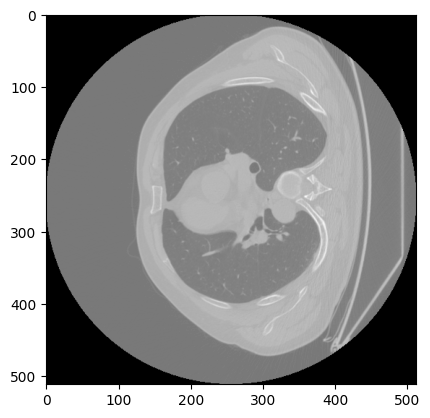

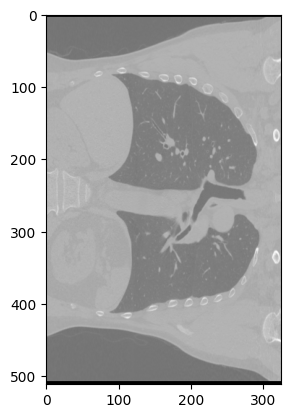

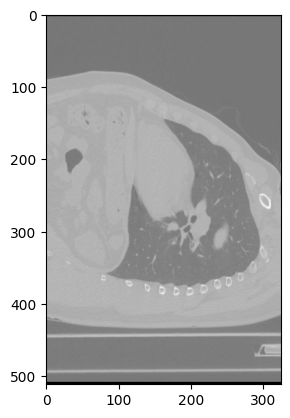

In [10]:
import matplotlib.pyplot as plt

# plot the image
plt.imshow(image_data[:,:,200], cmap='gray')
plt.show()

plt.imshow(image_data[:,300,:], cmap='gray')
plt.show()

plt.imshow(image_data[300,:,:], cmap='gray')
plt.show()

In [5]:
print(label_data.shape)
print(header)

(512, 512, 325)
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512 325   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int32
bitpix          : 32
slice_start     : 0
pixdim          : [1.       0.878906 0.878906 1.25     0.       0.       0.       0.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : unknown
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 203.6
qoffset_y       : 225.0
qoffset_z 

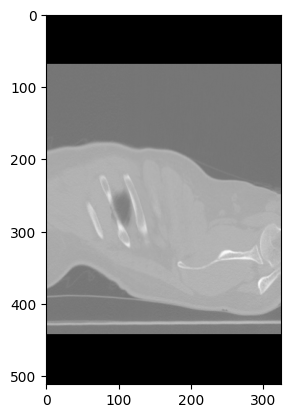

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


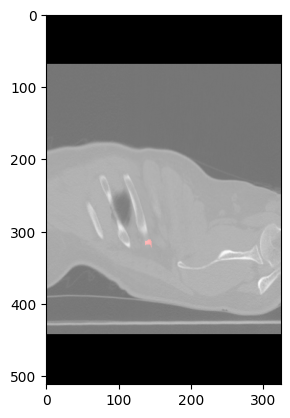

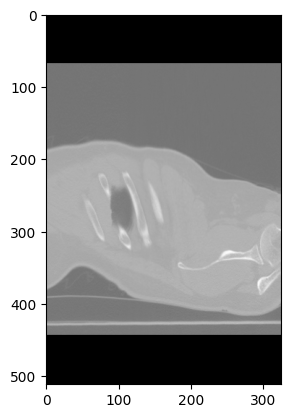

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


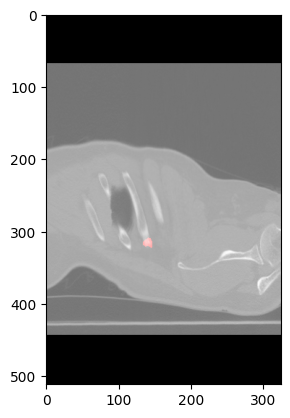

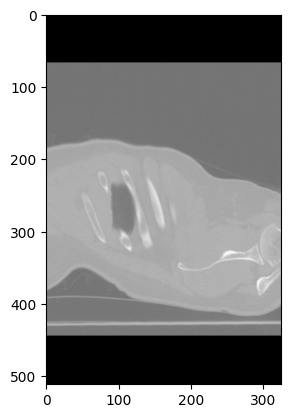

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


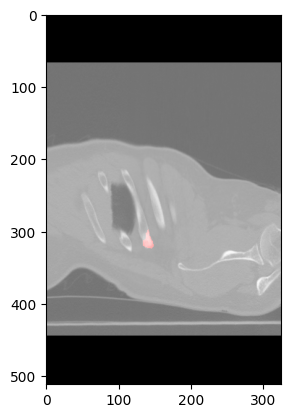

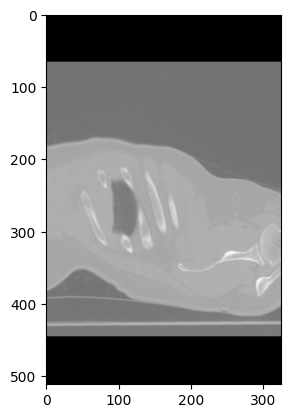

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


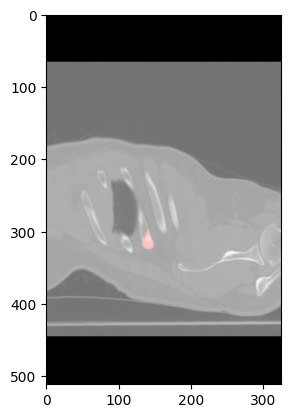

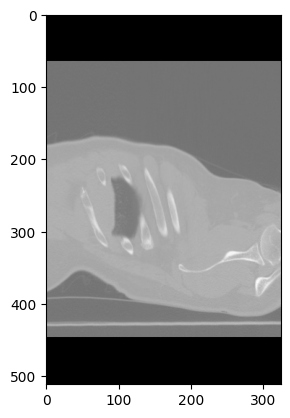

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


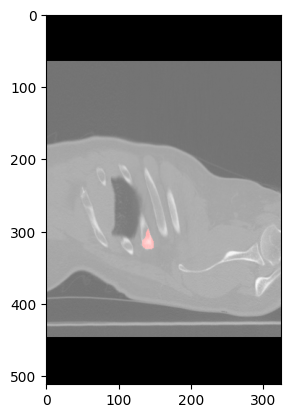

In [32]:
import numpy as np

# plot the slices with annotation
dimension = 0 # 0 sagital, 1 coronal, 2 transaxial
stop = 5
count = 0
for i in range(label_data.shape[dimension]):
    if dimension == 0:
        slice = label_data[i,:,:]
    elif dimension == 1:
        slice = label_data[:,i,:]
    else:
        slice = label_data[:,:,i]
    if slice.sum() > 0:
        if dimension == 0:
            img = image_data[i,:,:]
        elif dimension == 1:
            img = image_data[:,i,:]
        else:
            img = image_data[:,:,i]
        # normalize image and slice
        img = (img - img.min()) / (img.max() - img.min())
        slice = (slice - slice.min()) / (slice.max() - slice.min())
        # extend image to rgb
        img = np.stack((img,)*3, axis=-1)
        plt.imshow(img)
        plt.show()
        # highlight the area in image corresponding to where slice != 0 in red
        highlighted_image = img.copy()
        highlighted_image[:,:,0] = img[:,:,0] + slice
        plt.imshow(highlighted_image)
        plt.show()
        count += 1
        if count == stop:
            break

## 2 Pre-Processing

### Making them all the same shape

I do not hink this is a good approach because it adds latency to the data loading.
We should rather downsample the 3rd dimension.
Maybe after downsampling apply this function.

In [7]:
import numpy as np
from tqdm import tqdm as tqmd

override = False
mode = 'val' # 'train', 'val', 'test'

# find image with the most slices in 3rd dimension
max_slices = 0
print("finding largest file...")
for file in tqmd(os.listdir(os.path.join(path, f'data/ribfrac-{mode}-images'))):
    image_data, _ = read_image(os.path.join(path, f'data/ribfrac-{mode}-images', file))
    if image_data.shape[2] > max_slices:
        max_slices = image_data.shape[2]
        max_slices_file = file
print("largest file, size:", max_slices_file, max_slices)

# make a new folder to store the preprocessed data
if not os.path.exists(os.path.join(path, 'data/preprocessed')):
    os.makedirs(os.path.join(path, 'data/preprocessed'))
if not os.path.exists(os.path.join(path, f'data/preprocessed/ribfrac-{mode}-images')):
    os.makedirs(os.path.join(path, f'data/preprocessed/ribfrac-{mode}-images'))
if not os.path.exists(os.path.join(path, f'data/preprocessed/ribfrac-{mode}-labels')):
    os.makedirs(os.path.join(path, f'data/preprocessed/ribfrac-{mode}-labels'))

# pad all images to the same size
print("pre-processing images...")
for file in tqmd(os.listdir(os.path.join(path, f'data/ribfrac-{mode}-images'))):
    # check if file has been processed
    if not os.path.exists(os.path.join(path, f'data/preprocessed/ribfrac-{mode}-images', file)):
        image_data, _ = read_image(os.path.join(path, f'data/ribfrac-{mode}-images', file))
        label_data, _ = read_image(os.path.join(path, f'data/ribfrac-{mode}-labels', file.replace('image', 'label')))
        if image_data.shape[2] < max_slices:
            image_data = np.pad(image_data, ((0, 0), (0, 0), (0, max_slices - image_data.shape[2])), 'constant')
            label_data = np.pad(label_data, ((0, 0), (0, 0), (0, max_slices - label_data.shape[2])), 'constant')
            nib.save(
                nib.Nifti1Image(image_data, np.eye(4)),
                os.path.join(path, f'data/preprocessed/ribfrac-{mode}-images', file)
                )
            nib.save(
                nib.Nifti1Image(label_data, np.eye(4)),
                os.path.join(path, f'data/preprocessed/ribfrac-{mode}-labels', file.replace('image', 'label'))
                )

finding largest file...


  0%|          | 0/80 [00:00<?, ?it/s]


KeyboardInterrupt: 

### Make labels all 1 instead of 1, 2, 3, 4, -1